# Домашнее задание 3

В этом задании напишем простое решение классификации датасета `FashionMNIST`, а затем будем его улучшать с помощью:
- dropout;
- batch normalization;
- LR scheduler;

В конце сохраним модель в файл и убедимся, что этот файл можем в дальнейшем прочитать.

In [1]:
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor

In [2]:
train_dataset = FashionMNIST(
    root="./data", train=True, download=True, transform=ToTensor()
)
test_dataset = FashionMNIST(
    root="./data", train=False, download=True, transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:03<00:00, 8676583.07it/s] 


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 556844.49it/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6668629.80it/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



In [3]:
X_train = train_dataset.data.float()
y_train = train_dataset.targets
X_test = test_dataset.data.float()
y_test = test_dataset.targets

In [4]:
@dataclass
class TrainConfig:
    lr: float = 1e-3
    total_iterations: int = 100


# Для оценки будем использовать метрику accuracy
# Подумайте (опционально), какие еще метрики можно использовать
def calculate_accuracy(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_true).float().sum()
    accuracy = correct / y_true.shape[0]
    return accuracy.item()

## Задание №1

Попробуйте реализовать простой бейзлайн с несколькими слоями:
- Linear
- ReLU
- Linear

Вставьте свою релизацию `SimpleModel` в проверку.
Вам нужно дописать и сдать как `SimpleModel`, так и `train_loop`.

Используйте кросс-энтропию как функцию потерь.

In [6]:
from matplotlib import pyplot as plt


# Возможно, класс нужно отнаследовать от некого класса из pytorch
class SimpleModel(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        hidden_dim = 512
        self.net = nn.Sequential(
            nn.Linear(in_features=28 * 28, out_features=hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim, out_features=num_classes),
            # nn.Softmax(dim=1),
        )

    def forward(self, x: torch.Tensor):
        x = x.reshape((-1, 28 * 28))
        return self.net(x)


def train_loop(
        model: nn.Module,
        X_train: torch.Tensor,
        y_train: torch.Tensor,
        X_val: torch.Tensor,
        y_val: torch.Tensor,
        config: TrainConfig,
):
    """Обучите здесь модель, подсчитайте метрики на валидационной выборке.

    Можете так же писать/рисовать accuracy в процессе обучения.
    Например, каждые 10 итераций или даже каждую итерацию.
    """
    # Оставьте такое название перменной, это требование проверяющей системы
    optimizer = optim.SGD(lr=config.lr, params=model.parameters())
    model.train()

    train_losses = []
    val_losses = []
    val_accuracies = []

    for iteration in range(config.total_iterations):
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = F.cross_entropy(y_pred, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.detach().cpu().item())

        if (iteration + 1) % 10 == 0:
            with torch.no_grad():
                model.eval()
                loss_val = F.cross_entropy(model(X_val), y_val)
                val_losses.append(loss_val.item())
                accuracy = calculate_accuracy(model(X_val), y_val)
                val_accuracies.append(accuracy)

                model.train()
                print(f"Iteration: {iteration + 1}, Loss_val: {loss_val.item()}, Accuracy_val: {accuracy}")

    plt.figure(figsize=(12, 5))

    # График loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(range(0, config.total_iterations, 10), val_losses, label='Validation Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss over iterations')
    plt.legend()

    # График accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(0, config.total_iterations, 10), val_accuracies, label='Validation Accuracy', color='orange')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over iterations')
    plt.legend()

    plt.show()



## Задание №2
Какое максимальное значение метрики accuracy удалось получить в процессе обучения?

Округлите до 3 значений после запятой


Iteration: 10, Loss_val: 1.4601500034332275, Accuracy_val: 0.6309000253677368
Iteration: 20, Loss_val: 1.095395565032959, Accuracy_val: 0.6922000050544739
Iteration: 30, Loss_val: 0.9865127205848694, Accuracy_val: 0.7141000032424927
Iteration: 40, Loss_val: 0.920861542224884, Accuracy_val: 0.7269999980926514
Iteration: 50, Loss_val: 0.8741050958633423, Accuracy_val: 0.7354999780654907
Iteration: 60, Loss_val: 0.8379025459289551, Accuracy_val: 0.743399977684021
Iteration: 70, Loss_val: 0.8085730671882629, Accuracy_val: 0.7509999871253967
Iteration: 80, Loss_val: 0.7841757535934448, Accuracy_val: 0.7565000057220459
Iteration: 90, Loss_val: 0.7630903124809265, Accuracy_val: 0.7602999806404114
Iteration: 100, Loss_val: 0.7448229193687439, Accuracy_val: 0.7635999917984009


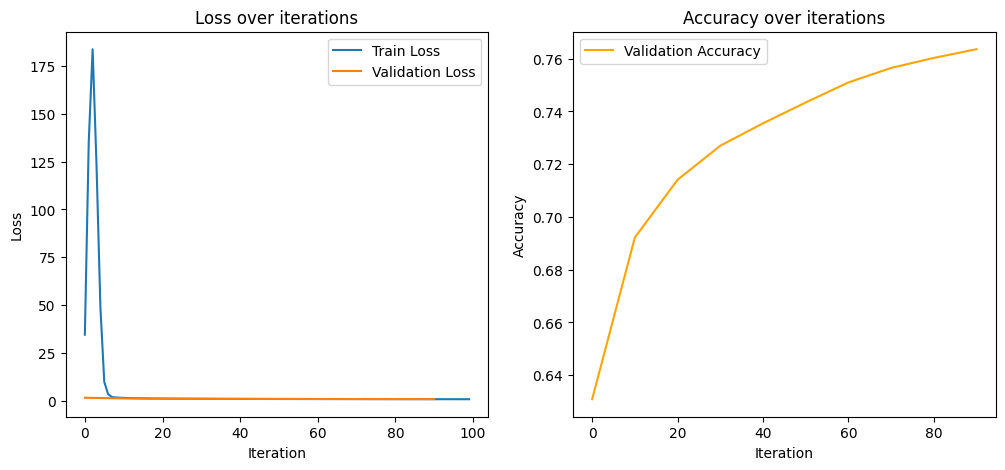

In [7]:
torch.manual_seed(987)
# дефолтные значения
config = TrainConfig()
train_loop(SimpleModel(10), X_train, y_train, X_test, y_test, config)

## Задание №3
Добавьте один `dropout` слой в вашу модель.

_Подумайте, что может поменяться при перестановке ReLU и Dropout слоев местами._

In [10]:
# Возможно, класс нужно отнаследовать от некого класса из pytorch
class DropoutModel(nn.Module):
    def __init__(self, num_classes: int, dropout_rate: float):
        super().__init__()
        hidden_dim = 512
        self.net = nn.Sequential(
            nn.Linear(in_features=28 * 28, out_features=hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features=hidden_dim, out_features=num_classes),
        )

    def forward(self, x: torch.Tensor):
        x = x.reshape((-1, 28 * 28))
        return self.net(x)

Iteration: 10, Loss_val: 1.4416614770889282, Accuracy_val: 0.6920999884605408
Iteration: 20, Loss_val: 1.0613905191421509, Accuracy_val: 0.7310000061988831
Iteration: 30, Loss_val: 0.9267922639846802, Accuracy_val: 0.7450000047683716
Iteration: 40, Loss_val: 0.8522641658782959, Accuracy_val: 0.7531999945640564
Iteration: 50, Loss_val: 0.8037592172622681, Accuracy_val: 0.7628999948501587
Iteration: 60, Loss_val: 0.7683224678039551, Accuracy_val: 0.7694000005722046
Iteration: 70, Loss_val: 0.7405760884284973, Accuracy_val: 0.7739999890327454
Iteration: 80, Loss_val: 0.7191398739814758, Accuracy_val: 0.7788000106811523
Iteration: 90, Loss_val: 0.7024048566818237, Accuracy_val: 0.781000018119812
Iteration: 100, Loss_val: 0.687388002872467, Accuracy_val: 0.7839999794960022


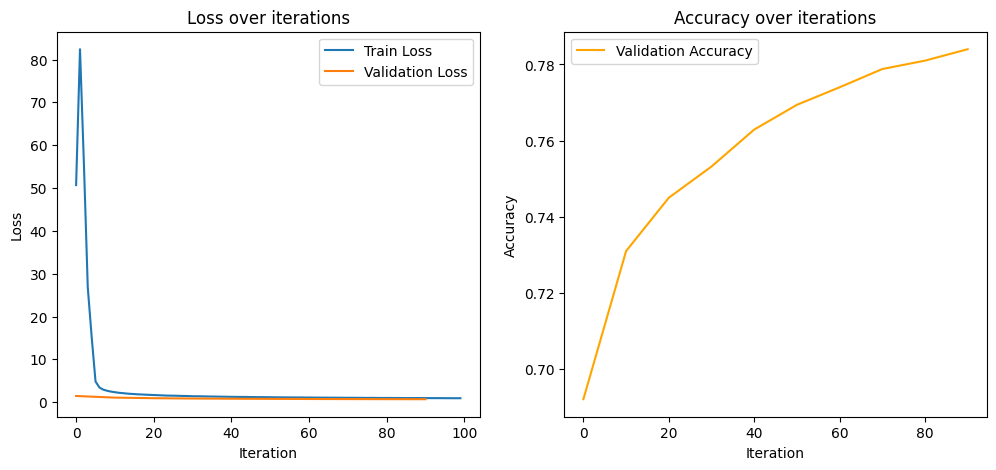

In [11]:
torch.manual_seed(987)
config = TrainConfig()
train_loop(DropoutModel(10, 0.5), X_train, y_train, X_test, y_test, config)

## Задание №4
Какое максимальное значение accuracy получилось в ходе обучения модели? 

Округлите до 3х знаков после запятой и отправьте в ЛМС.

## Задание №5

Добавьте `BatchNorm` в вашу модель.
Отправьте в ЛМС реализацию.

Стоит ли делать BatchNorm до ReLU или после него?
Это дискуссионный вопрос, чаще всего применяют сначала нелинейность, затем Batch Norm.
Один из аргументов: при таком подходе данные на выходе будут иметь среднее 0 - что и ожидают люди, когда добавляют нормализацию.

_[Дискуссия на Reddit](https://www.reddit.com/r/MachineLearning/comments/67gonq/d_batch_normalization_before_or_after_relu/)_

Для определенности в этом задании будем следовать такому порядку: сначала ReLU, затем Batch Norm.

In [12]:
# Возможно, класс нужно отнаследовать от некого класса из pytorch
class BatchNormModel(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        hidden_dim = 512
        self.net = nn.Sequential(
            nn.Linear(in_features=28 * 28, out_features=hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=hidden_dim),
            nn.Linear(in_features=hidden_dim, out_features=num_classes),
        )

    def forward(self, x: torch.Tensor):
        x = x.reshape((-1, 28 * 28))
        return self.net(x)

Iteration: 10, Loss_val: 2.0149614810943604, Accuracy_val: 0.27230000495910645
Iteration: 20, Loss_val: 1.731325626373291, Accuracy_val: 0.45329999923706055
Iteration: 30, Loss_val: 1.5499143600463867, Accuracy_val: 0.5444999933242798
Iteration: 40, Loss_val: 1.4169436693191528, Accuracy_val: 0.6035000085830688
Iteration: 50, Loss_val: 1.3158609867095947, Accuracy_val: 0.6370000243186951
Iteration: 60, Loss_val: 1.2367886304855347, Accuracy_val: 0.6575999855995178
Iteration: 70, Loss_val: 1.173340916633606, Accuracy_val: 0.6759999990463257
Iteration: 80, Loss_val: 1.1216329336166382, Accuracy_val: 0.6876000165939331
Iteration: 90, Loss_val: 1.078918218612671, Accuracy_val: 0.6970000267028809
Iteration: 100, Loss_val: 1.0428993701934814, Accuracy_val: 0.7039999961853027


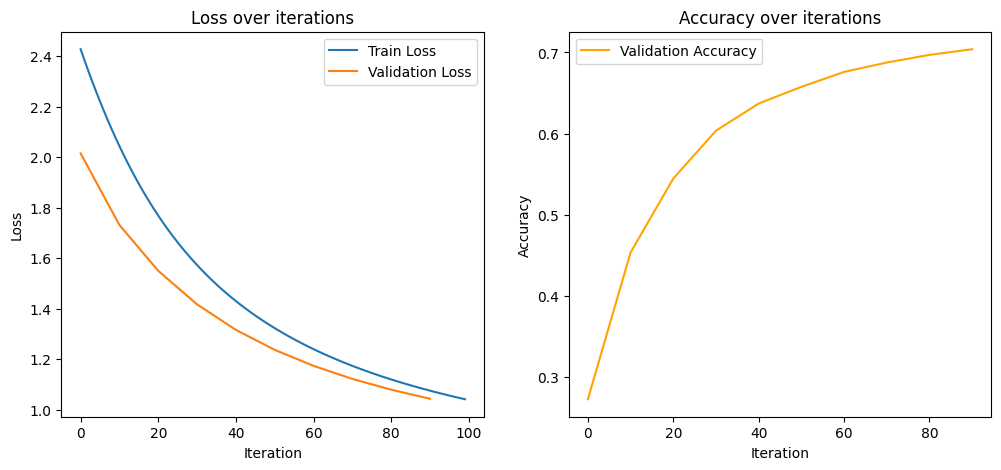

In [13]:
torch.manual_seed(987)
config = TrainConfig()
train_loop(BatchNormModel(10), X_train, y_train, X_test, y_test, config)

## Задание №6
Какое максимальное значение `accuracy` получилось в ходе обучения модели? 

Округлите до 3х знаков после запятой.

Результат batch normalization мог не особо порадовать.
Но не спешите с выводами насчет этого слоя!

Попробуйте обучить заново все три модели со значением `lr=1e-2` (в 10 раз больше).
Сравните результаты моделей и сделайте вывод.

## Задание №7
Добавьте `LRscheduler` в вашу модель.

Подробнее про `schedulers` можно почитать в [документации](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)

In [17]:
from torch.optim.lr_scheduler import StepLR


def train_loop_with_scheduler(
        model,
        X_train: torch.Tensor,
        y_train: torch.Tensor,
        X_val: torch.Tensor,
        y_val: torch.Tensor,
        config: TrainConfig,
):
    optimizer = optim.SGD(lr=config.lr, params=model.parameters())
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
    model.train()

    train_losses = []
    val_losses = []
    val_accuracies = []

    for iteration in range(config.total_iterations):
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = F.cross_entropy(y_pred, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.detach().cpu().item())

        if (iteration + 1) % 10 == 0:
            with torch.no_grad():
                model.eval()
                loss_val = F.cross_entropy(model(X_val), y_val)
                val_losses.append(loss_val.item())
                accuracy = calculate_accuracy(model(X_val), y_val)
                val_accuracies.append(accuracy)

                model.train()
                print(f"Iteration: {iteration + 1}, Loss_val: {loss_val.item()}, Accuracy_val: {accuracy}")

        scheduler.step()

    plt.figure(figsize=(12, 5))

    # График loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(range(0, config.total_iterations, 10), val_losses, label='Validation Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss over iterations')
    plt.legend()

    # График accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(0, config.total_iterations, 10), val_accuracies, label='Validation Accuracy', color='orange')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over iterations')
    plt.legend()

    plt.show()

In [14]:
torch.manual_seed(987)
config = TrainConfig(lr=1e-3)
# Ваш код для обучения и подсчета accuracy

## Задание №8

Поэксперементируйте с параметрами нейронной сети, попробуйте добиться максимальной метрики `accuracy`.

- попробуйте комбинацию Drouput + Batch Normalization и подумайте, как лучше всего раскрыть силу batch normalization (вспомните эксперименты с lr);
- попробуйте подвигать вероятность в Dropout;
- ну, или подержите обучение подольше, поставив больше шагов :)

В ЛМС нужно сдать код класса `ExpModel`.
Вам необходимо выбить accuracy > 80%, чтобы сдать этот пункт.

Iteration: 10, Loss_val: 1.2881745100021362, Accuracy_val: 0.675599992275238
Iteration: 20, Loss_val: 1.020937442779541, Accuracy_val: 0.7131999731063843
Iteration: 30, Loss_val: 0.9119015336036682, Accuracy_val: 0.7355999946594238
Iteration: 40, Loss_val: 0.8479100465774536, Accuracy_val: 0.7479000091552734
Iteration: 50, Loss_val: 0.8040036559104919, Accuracy_val: 0.7563999891281128
Iteration: 60, Loss_val: 0.7714556455612183, Accuracy_val: 0.7630000114440918
Iteration: 70, Loss_val: 0.746017575263977, Accuracy_val: 0.7684999704360962
Iteration: 80, Loss_val: 0.7253999710083008, Accuracy_val: 0.7735000252723694
Iteration: 90, Loss_val: 0.7079049944877625, Accuracy_val: 0.7768999934196472
Iteration: 100, Loss_val: 0.6931004524230957, Accuracy_val: 0.7799000144004822
Iteration: 110, Loss_val: 0.6799982190132141, Accuracy_val: 0.7827000021934509
Iteration: 120, Loss_val: 0.6683415174484253, Accuracy_val: 0.784600019454956
Iteration: 130, Loss_val: 0.6578065156936646, Accuracy_val: 0.787

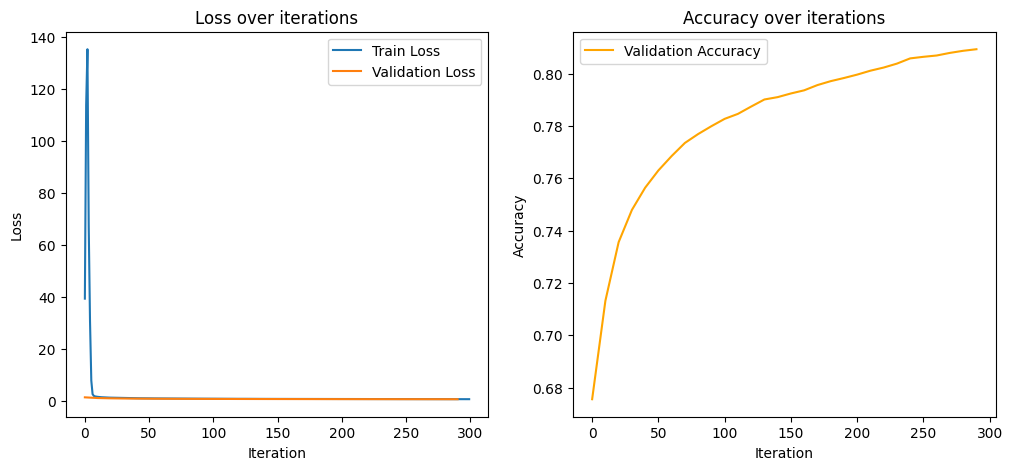

In [24]:
torch.manual_seed(987)

class ExpModel(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        hidden_dim = 512
        self.net = nn.Sequential(
            nn.Linear(in_features=28 * 28, out_features=hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=hidden_dim, out_features=num_classes),
        )

    def forward(self, x: torch.Tensor):
        x = x.reshape((-1, 28 * 28))
        return self.net(x)

model = ExpModel(10)
config = TrainConfig(total_iterations=300)
train_loop(model, X_train, y_train, X_test, y_test, config)

Наконец, сохраним лучшую модель, чтобы в будущем ее могли взять и использовать, без обучения.

## Задание №9

Напишите код, который сохранит модель в файл `model.pt`.

In [25]:
torch.save(model.state_dict(), "model.pt")

In [29]:
# Впоследствии эту модель можно будет загрузить вот так:
model_loaded = ExpModel(num_classes=len(y_test.unique()))
model_loaded.load_state_dict(torch.load("model.pt"))